In [41]:
# 1. Data read in
# 2. Data quality check
# 3. Data preparation
# 4. Model training
# 5. Model evaluation
# 6. Model validation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # Visualization
import seaborn as sns #Visualization
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['font.size'] =14
plt.rcParams['font.weight']= 'bold'
import scipy 
from scipy import stats 
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import math


1. Data read in

In [7]:
df = pd.read_csv("Prostate.txt", delimiter='\t', index_col=0)
df

# Predictors (columns 1--8)

# lcavol
# lweight
# age
# lbph
# svi
# lcp
# gleason
# pgg45

# outcome (column 9)

# lpsa

# train/test indicator (column 10)

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T
...,...,...,...,...,...,...,...,...,...,...
93,2.830268,3.876396,68,-1.386294,1,1.321756,7,60,4.385147,T
94,3.821004,3.896909,44,-1.386294,1,2.169054,7,40,4.684443,T
95,2.907447,3.396185,52,-1.386294,1,2.463853,7,10,5.143124,F
96,2.882564,3.773910,68,1.558145,1,1.558145,7,80,5.477509,T


2. Data Quality Check

<class 'pandas.core.frame.DataFrame'>
Index: 97 entries, 1 to 97
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   lcavol   97 non-null     float64
 1   lweight  97 non-null     float64
 2   age      97 non-null     int64  
 3   lbph     97 non-null     float64
 4   svi      97 non-null     int64  
 5   lcp      97 non-null     float64
 6   gleason  97 non-null     int64  
 7   pgg45    97 non-null     int64  
 8   lpsa     97 non-null     float64
 9   train    97 non-null     object 
dtypes: float64(5), int64(4), object(1)
memory usage: 8.3+ KB


C:\Users\levor\AppData\Local\Temp\ipykernel_9796\2217936697.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['lpsa'],bins=50,color='r',ax=ax)
c:\Users\levor\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\levor\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\levor\AppData\Local\Temp\ipykernel_9796\2217936

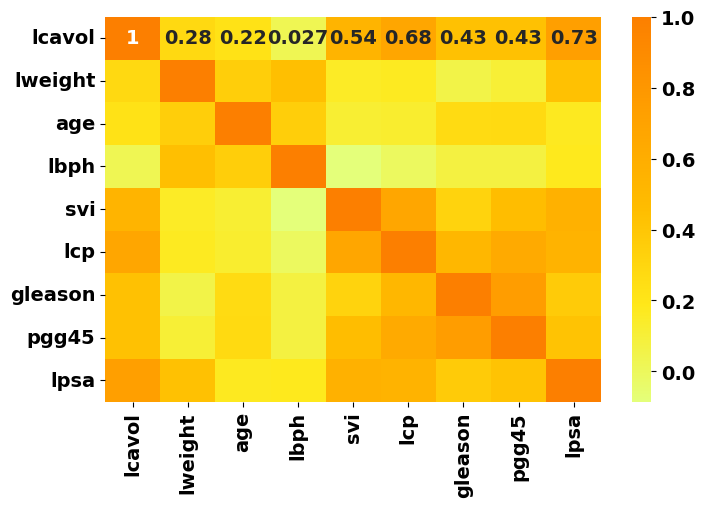

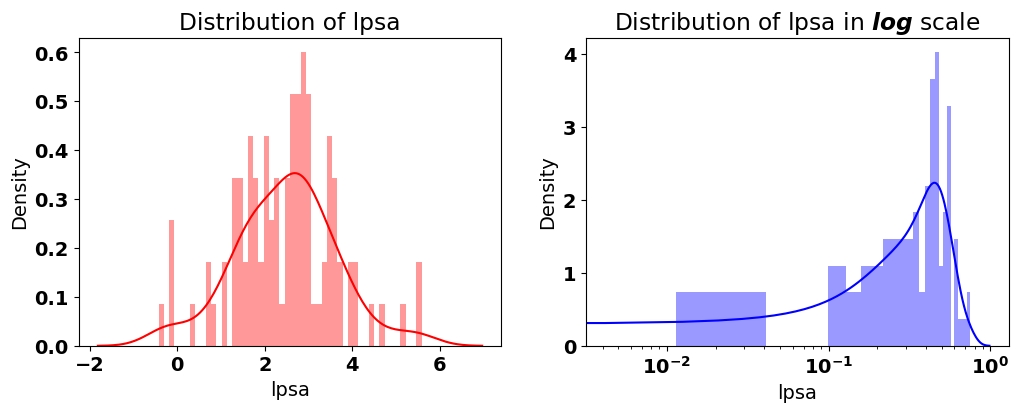

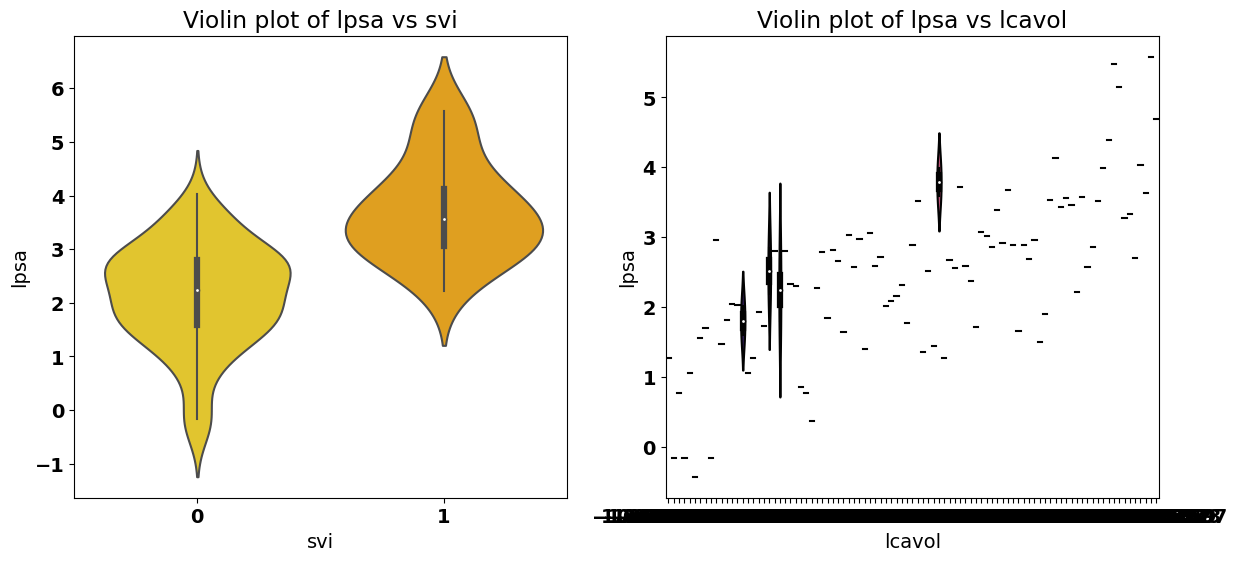

In [91]:
# Overall
df.info()
df.describe()
# correlation plot
ds = df.drop(columns=['train'], axis=1)

# Correlation
corr = ds.corr()
sns.heatmap(corr, cmap = 'Wistia', annot= True);

# Distribution of target variable

f= plt.figure(figsize=(12,4))

ax=f.add_subplot(121)
sns.distplot(df['lpsa'],bins=50,color='r',ax=ax)
ax.set_title('Distribution of lpsa')

ax=f.add_subplot(122)
sns.distplot(np.log10(df['lpsa']),bins=40,color='b',ax=ax)
ax.set_title('Distribution of lpsa in $log$ scale')
ax.set_xscale('log');


# Violin plot of lpsa vs. lcavol  and lpsa vs. svi
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.violinplot(x='svi', y='lpsa',data=df,palette='Wistia',ax=ax)
ax.set_title('Violin plot of lpsa vs svi')

ax = f.add_subplot(122)
sns.violinplot(x='lcavol', y='lpsa',data=df,palette='magma',ax=ax)
ax.set_title('Violin plot of lpsa vs lcavol');


3. Data preparation

In [103]:
# No need to do any dummy variable transformation
# No need to log transform the target variable

# We split the sample into Train (train = T) and Test (train = F)

trainSample = df.loc[df['train'] == "T"]
testSample = df.loc[df['train'] == "F"]

# Prepare Train Sample
X_Train = trainSample.drop(columns = ['lpsa','train', 'age','lcp','gleason','pgg45'], axis=1)

if True:
    cols = X_Train.columns

    for i in range(len(cols)):
        # Z-Score using scipy 
        X_Train[cols[i]] = stats.zscore(X_Train[cols[i]]) 

Y_Train= trainSample['lpsa'].values

# Prepare Test Sample
X_Test = testSample.drop(columns = ['lpsa','train', 'age','lcp','gleason','pgg45'], axis=1)

if True:
    cols = X_Test.columns

    for i in range(len(cols)):
        # Z-Score using scipy 
        X_Test[cols[i]] = stats.zscore(X_Test[cols[i]]) 

Y_Test= testSample['lpsa'].values

4. Model training

In [93]:
#Train Model and produce results
X_Train = sm.add_constant(X_Train, prepend=False)

model = sm.OLS(Y_Train,X_Train)
result = model.fit()
result.summary()

# Coefficient / Std Error = Z-Score
###########################################################################################

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     29.98
Date:                Mon, 22 Apr 2024   Prob (F-statistic):           6.91e-14
Time:                        11:00:08   Log-Likelihood:                -71.156
No. Observations:                  67   AIC:                             152.3
Df Residuals:                      62   BIC:                             163.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
lcavol         0.6234      0.114      5.461      0.000       0.395       0.852
lweight        0.2549      0.104      2.441      0.018       0.046       0.464
lbph           0.2034      0.102      1.988      0.051      -0.001       0.408
svi            0.2801      0.114      2.459      0.017       0.052       0.508
const          2.4523      0.089     27.592      0.000       2.275       2.630
==============================================================================
Omnibus:                        0.907   Durbin-Watson:                   1.800
Prob(Omnibus):                  0.635   Jarque-Bera (JB):                0.732
Skew:                          -0.254   Prob(JB):                        0.694
Kurtosis:                       2.940   Cond. No.                         2.19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [104]:
# Step 1: add x0 =1 to dataset
X_train_0 = np.c_[np.ones((X_Train.shape[0],1)),X_Train]
X_test_0 = np.c_[np.ones((X_Test.shape[0],1)),X_Test]


# Step2: build model
theta = np.matmul(np.linalg.inv( np.matmul(X_train_0.T,X_train_0) ), np.matmul(X_train_0.T,Y_Train)) 

# The parameters for linear regression model
parameter = ['theta_'+str(i) for i in range(X_train_0.shape[1])]
columns = ['intersect:x_0=1'] + list(X_Train.columns.values)
parameter_df = pd.DataFrame({'Parameter':parameter,'Columns':columns,'theta':theta})

# Scikit Learn module
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_Train,Y_Train) # Note: x_0 =1 is no need to add, sklearn will take care of it.

#Parameter
sk_theta = [lin_reg.intercept_]+list(lin_reg.coef_)
parameter_df = parameter_df.join(pd.Series(sk_theta, name='Sklearn_theta'))
parameter_df

,Parameter,Columns,theta,Sklearn_theta
0,theta_0,intersect:x_0=1,2.452345,2.452345
1,theta_1,lcavol,0.623450,0.623450
2,theta_2,lweight,0.254883,0.254883
3,theta_3,lbph,0.203393,0.203393
4,theta_4,svi,0.280055,0.280055


5. Model Evaluation

In [105]:
# Normal equation
y_pred_norm =  np.matmul(X_test_0,theta)

#Evaluvation: MSE
J_mse = np.sum((y_pred_norm - Y_Test)**2)/ X_test_0.shape[0]

# R_square 
sse = np.sum((y_pred_norm - Y_Test)**2)
sst = np.sum((Y_Test - Y_Test.mean())**2)
R_square = 1 - (sse/sst)
print('The Mean Square Error(MSE) or J(theta) is: ',J_mse)
print('R square obtain for normal equation method is :',R_square)

The Mean Square Error(MSE) or J(theta) is:  0.4918735816108727
R square obtain for normal equation method is : 0.5313897697131332


6. Model Validation (Hypotehises Testing)

In order to validated the model we need to check few assumption of linear regression model. The common assumption for Linear Regression model are following

1. Linear Relationship: In linear regression the relationship between the dependent and independent variable to be linear. This can be checked by scatter ploting Actual value Vs Predicted value
2. The residual error plot should be normally distributed.
3. The mean of residual error should be 0 or close to 0 as much as possible
4. The linear regression require all variables to be multivariate normal. This assumption can best checked with Q-Q plot.
5. Linear regession assumes that there is little or no Multicollinearity in the data. Multicollinearity occurs when the independent variables are too highly correlated with each other. The variance inflation factor VIF* identifies correlation between independent variables and strength of that correlation.  VIF=11−R2, If VIF >1 & VIF <5 moderate correlation, VIF < 5 critical level of multicollinearity.
6. Homoscedasticity: The data are homoscedastic meaning the residuals are equal across the regression line. We can look at residual Vs fitted value scatter plot. If heteroscedastic plot would exhibit a funnel shape pattern.

C:\Users\levor\AppData\Local\Temp\ipykernel_9796\4014173773.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((Y_Test - y_pred_sk),ax=ax,color='b')
c:\Users\levor\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


3.26797385620915

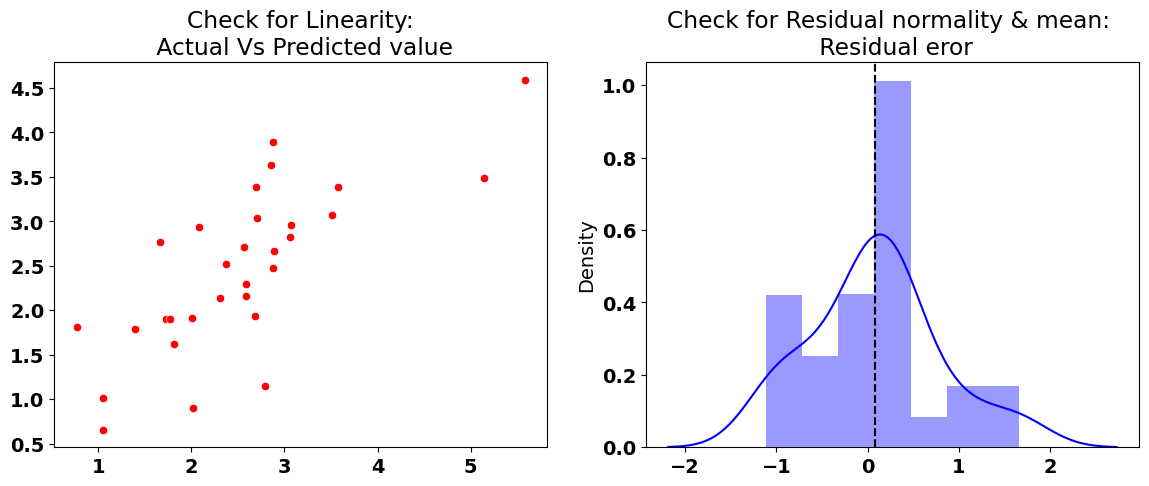

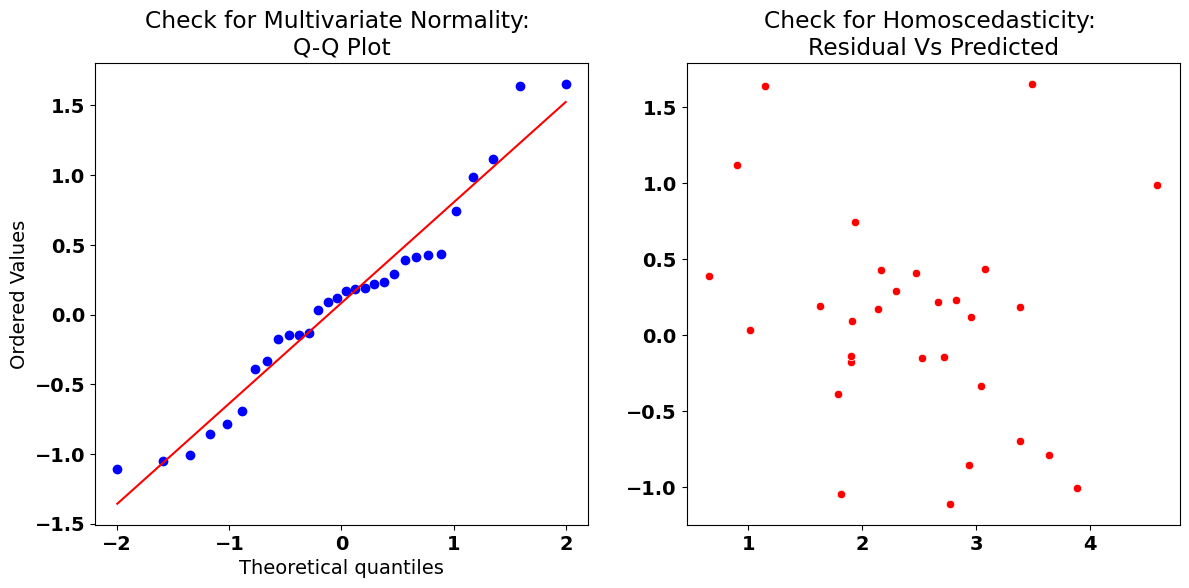

In [106]:
# sklearn regression module
y_pred_sk = lin_reg.predict(X_Test)

# Check for Linearity
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
sns.scatterplot(x=Y_Test,y=y_pred_sk,ax=ax,color='r')
ax.set_title('Check for Linearity:\n Actual Vs Predicted value')

# Check for Residual normality & mean
ax = f.add_subplot(122)
sns.distplot((Y_Test - y_pred_sk),ax=ax,color='b')
ax.axvline((Y_Test - y_pred_sk).mean(),color='k',linestyle='--')
ax.set_title('Check for Residual normality & mean: \n Residual eror');

# Check for Multivariate Normality
# Quantile-Quantile plot 
f,ax = plt.subplots(1,2,figsize=(14,6))
import scipy as sp
_,(_,_,r)= sp.stats.probplot((Y_Test - y_pred_sk),fit=True,plot=ax[0])
ax[0].set_title('Check for Multivariate Normality: \nQ-Q Plot')

#Check for Homoscedasticity
sns.scatterplot(y = (Y_Test - y_pred_sk), x= y_pred_sk, ax = ax[1],color='r') 
ax[1].set_title('Check for Homoscedasticity: \nResidual Vs Predicted');

# Check for Multicollinearity
#Variance Inflation Factor -> has to be > 5
VIF = 1/(1- 0.694)
VIF
 
